<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №5 "Рекуррентные сети и одномерная свертка" 23.08.2020

Борис Грибовский <xinu@yandex.ru>

## Подготовка данных


In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

import os
import random
import time

In [ ]:
# Загружаем базу писателей
!wget https://xland.ru/uai/hw04/writers.zip
!unzip -q 'writers.zip' -d /content/texts 

--2020-08-24 11:34:19--  https://xland.ru/uai/hw04/writers.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960427 (8.5M) [application/zip]
Saving to: ‘writers.zip’

writers.zip         100%[===================>]   8.54M  11.2MB/s    in 0.8s    

2020-08-24 11:34:20 (11.2 MB/s) - ‘writers.zip’ saved [8960427/8960427]



In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/texts/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/texts/(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Рэй Брэдберри) Обучающая_22 вместе.txt')) 
# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/texts/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/texts/(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Рэй Брэдберри) Тестовая_8 вместе.txt'))

In [ ]:
maxWordsCount = 20000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
tokenizer.fit_on_texts(trainText) 
items = list(tokenizer.word_index.items())

In [ ]:
print(items[:100])


[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('сказал', 27), ('бы', 28), ('было', 29), ('вы', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('когда', 39), ('вот', 40), ('уже', 41), ('если', 42), ('был', 43), ('ни', 44), ('их', 45), ('нет', 46), ('чтобы', 47), ('до', 48), ('ну', 49), ('для', 50), ('ему', 51), ('может', 52), ('или', 53), ('ничего', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('него', 63), ('чем', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('время', 72), ('ли', 73), ('тебе', 74), ('со', 75), ('во', 76), ('вас', 77), ('раз'

In [ ]:
tokenizer.word_index['белый']

953

In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 6 классов на n*20000 и xTestEm 6 по n*1000

def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

In [ ]:
xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)

## LIGHT

### Embedding + Dense сеть.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 16)          320000    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1000, 16)          64        
_________________________________________________________________
flatten_7 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2048128   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 774       
Total params: 2,368,966
Trainable params: 2,368,934
Non-trainable params: 32
___________________________________________

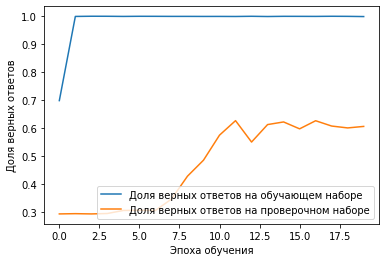

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  39 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  67 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  60 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  46 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  69 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  55 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  60 %



In [ ]:
epochs = 20
name = "Embedding + Dense"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(model, xTest6Classes, name) 

### Embedding + LSTM сеть.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 16)          320000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1000, 16)          64        
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
batch_normalization_16 (Batc (None, 16)                64        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 102       
Total params: 322,342
Trainable params: 322,278
Non-trainable params: 64
_______________________________________________

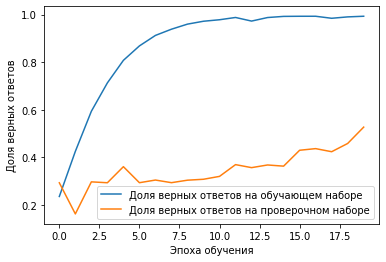

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  45 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  54 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  14 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  20 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  87 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  53 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  52 %



In [ ]:
epochs = 20
name = "Embedding + LSTM"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())
model.add(LSTM(16, dropout=0.1))
model.add(BatchNormalization())

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(model, xTest6Classes, name) 

### Embedding + Conv1D сеть.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 16)          320000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 20)           1620      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 20)           2020      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 247, 20)          

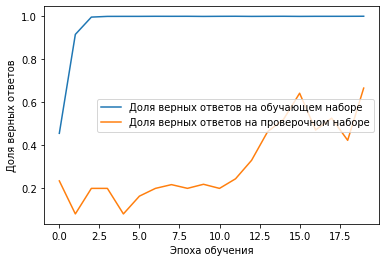

НЕЙРОНКА:  Embedding + Conv1D

О. Генри  распознано  46 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  95 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  53 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  53 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  71 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  61 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  66 %



In [ ]:
epochs = 20
name = "Embedding + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(Conv1D(20, 5, activation="relu")) 
model.add(MaxPooling1D(2)) 

model.add(Conv1D(20, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 

model.add(Flatten()) 
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(model, xTest6Classes, name)

### Embedding + сложная сеть из Dense, LSTM и Conv1D.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 16)          320000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1000, 16)          64        
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 4)           336       
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000, 4)           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1000, 4)          

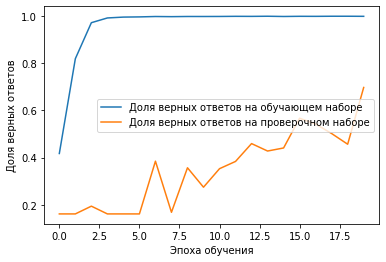

НЕЙРОНКА:  Embedding + Dense + LSTM + Conv1D

О. Генри  распознано  47 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  78 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  65 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  54 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  76 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  70 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  69 %



In [ ]:
epochs = 20
name = "Embedding + Dense + LSTM + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(SpatialDropout1D(0.2)) 
model.add(LSTM(4, return_sequences=1)) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 

model.add(Conv1D(20, 5, activation="relu")) 
model.add(Conv1D(20, 5, activation="relu")) 
model.add(MaxPooling1D(2)) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.2)) 

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(model, xTest6Classes, name)

## PRO

### Вариант1

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.
- Embedding + LSTM сеть.
- Embedding + Conv1D сеть.
- Embedding + сложная сеть из Dense, LSTM и Conv1D.

Добейтесь максимальной точности распознавания.
Используйте xLen = 50.


In [ ]:
!wget https://xland.ru/uai/hw04/diseases.zip

--2020-08-27 14:18:47--  https://xland.ru/uai/hw04/diseases.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32902 (32K) [application/zip]
Saving to: ‘diseases.zip’

diseases.zip        100%[===================>]  32.13K  --.-KB/s    in 0s      

2020-08-27 14:18:48 (257 MB/s) - ‘diseases.zip’ saved [32902/32902]



In [ ]:
!unzip diseases

Archive:  diseases.zip
   creating: diseases/
  inflating: diseases/Аппендицит.txt  
  inflating: diseases/Гастрит.txt  
  inflating: diseases/Гепатит.txt  
  inflating: diseases/Дуоденит.txt  
  inflating: diseases/Колит.txt  
  inflating: diseases/Панкреатит.txt  
  inflating: diseases/Холицестит.txt  
  inflating: diseases/Эзофагит.txt  
  inflating: diseases/Энтерит.txt  
  inflating: diseases/Язва.txt   


In [ ]:
diseases = []
for i in os.listdir('diseases'):
  diseases.append(i[:-4])
diseases

['Дуоденит',
 'Энтерит',
 'Панкреатит',
 'Аппендицит',
 'Гепатит',
 'Колит',
 'Эзофагит',
 'Язва',
 'Гастрит',
 'Холицестит']

In [ ]:
# эта функция берет содержимое указанного файла и разбивает его на фрагменты.
# В качестве разделителя фрагментов используется пустая строка. 
def splitFile(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n\n", "$") # Пустые строки помечаем как разделители фрагментов
  text = text.replace("\n", " ") # Переводы строк заменяем на пробелы
  return text.split('$')                    # Возвращаем список фрагментов

def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  return text  

In [ ]:
# Извлекаем данные из файлов в 2 списка
data = [] # категория + текст
texts = [] # только тексты
for i, name in enumerate(diseases):
  fname = f'diseases/{name}.txt'
  texts.append(readText(fname))
  symptoms = splitFile(fname)
  for symptom in symptoms:
    if len(symptom) > 0:
      data.append([i, symptom])
print(len(data))
nClasses = len(diseases)
nClasses

254


10

In [ ]:
# Перемешаем данные перед разбиением на тенировочную и тестовую выборки
random.shuffle(data)

In [ ]:
# Токенезируем все тектсты, составим словарь всех слов
maxWordsCount = 2000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts) 
items = list(tokenizer.word_index.items())

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 1981


In [ ]:
# Разделим данные на тренировочные и тестовые
trainTexts = []
trainClasses = []
testTexts = []
testClasses = []
for i, item in enumerate(data):
    if i < 0.8*len(data):
        trainClasses.append(item[0])
        trainTexts.append(item[1])
    else:
        testClasses.append(item[0])
        testTexts.append(item[1])

In [ ]:
# Преобразовываем тексты в последовательность индексов согласно частотному словарю
trainTokens = tokenizer.texts_to_sequences(trainTexts) # Обучающие тесты в индексы
testTokens = tokenizer.texts_to_sequences(testTexts)  # Проверочные тесты в индексы
print(len(trainTokens))
print(len(testTokens))
print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainTexts[1][:87])
print("Он же в виде последовательности индексов: ", trainTokens[1][:20], '\n')


204
50
Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               -Приступы протекают всегда одинаково, обычно начинаются поздно вечером: вначале тяжесть
Он же в виде последовательности индексов:  [122, 1960, 538, 1961, 94, 1962, 1963, 802, 1964, 66, 2, 316, 3, 2, 40, 35, 345, 4, 134, 3] 



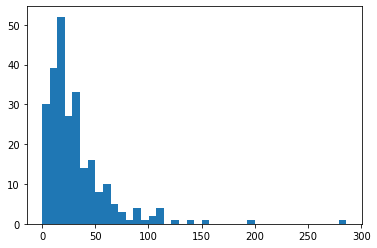

In [ ]:
# Посмотрим распределение по длине описания симптомов в выборках
lens = [len(x) for x in trainTokens + testTokens]
plt.hist(lens, 40)
plt.show()

In [ ]:
# Нарезаем последовательность токенов на набор фрагментов длины xLen)
def splitTokens(sequence, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(sequence) # Считаем количество слов
  if wordsLen <= xLen:
      return [sequence]
  index = 0 # Задаем начальный индекс 
  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(sequence[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
  return xSample

# Формирование обучающей и проверочной выборки
def createSamples(tokens, classes, xLen, step, nClasses): # Функция принимает последовательность индексов, размер окна, шаг окна
    xSamples = []
    ySamples = []
    for i, index in enumerate(tokens):
        cl = classes[i]
        xs = splitTokens(index, xLen, step) # получили список окон из одного образца
        xsp = pad_sequences(xs, maxlen=xLen) # дополним до длины xLen
        for x in xsp:
            # xSamples.append()
            xSamples.append(x)
            ySamples.append(utils.to_categorical(cl, nClasses))
    return np.array(xSamples), np.array(ySamples) 

In [ ]:
xLen = 50
step = 1
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSamples(trainTokens, trainClasses, xLen, step, nClasses) #извлекаем обучающую выборку
print(xTrain.shape)
print(yTrain.shape)
xTest, yTest = createSamples(testTokens, testClasses, xLen, step, nClasses)    #извлекаем тестовую выборку
print(xTest.shape)
print(yTest.shape)
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(1454, 50)
(1454, 10)
(346, 50)
(346, 10)
Время обработки: 0.27c


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 16)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 50, 16)            64        
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 53,706
Trainable params: 53,546
Non-trainable params: 160
________________________________________________

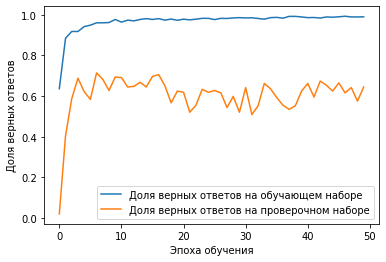

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

epochs = 50
name = "Embedding + LSTM"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(LSTM(64, dropout=0.2))
model.add(BatchNormalization())

model.add(Dense(nClasses, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model1.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=16,
                    callbacks=[checkpoint_callback],
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Загружаем лучшие найденные веса
model.load_weights('best_model1.h5')

In [ ]:
score = model.evaluate(xTest, yTest)
score

11/11 [==============================] - 0s 4ms/step - loss: 1.2900 - accuracy: 0.7139


[1.2900301218032837, 0.7138728499412537]

In [ ]:
def report(model, name):
    count = 0 # счетчик верных диагнозов
    N = len(testTokens)
    for i, tokens in enumerate(testTokens):
        cl = testClasses[i]
        # делаем из симптома tokens нарезку окон длиной xLen
        xSamples = splitTokens(tokens, xLen, step)
        xTest = pad_sequences(xSamples, maxlen=xLen)
        y = model.predict(xTest)
        Y_avg = np.mean(y, axis=0)
        cl_pred = np.argmax(Y_avg)
        if cl == cl_pred:
            count+= 1
        print(i, diseases[cl], diseases[cl_pred], Y_avg[cl_pred], len(xSamples), 'ВЕРНО' if cl == cl_pred else 'НЕ ВЕРНО')
    print("Модель: '%s' Точных диагнозов: %d/%d (%.1f%%)" % (name, count, N, count*100./N))
    
    

In [ ]:
report(model, 'Embedding + LSTM')

0 Панкреатит Панкреатит 0.8991945 1 ВЕРНО
1 Колит Колит 0.9180993 1 ВЕРНО
2 Гастрит Гастрит 0.8355233 40 ВЕРНО
3 Эзофагит Эзофагит 0.84344935 6 ВЕРНО
4 Гепатит Холицестит 0.85416436 1 НЕ ВЕРНО
5 Панкреатит Гастрит 0.84407455 16 НЕ ВЕРНО
6 Эзофагит Колит 0.3932415 1 НЕ ВЕРНО
7 Холицестит Панкреатит 0.9812775 1 НЕ ВЕРНО
8 Дуоденит Дуоденит 0.7692173 1 ВЕРНО
9 Колит Колит 0.9377342 1 ВЕРНО
10 Холицестит Эзофагит 0.6112295 1 НЕ ВЕРНО
11 Дуоденит Гастрит 0.9977253 4 НЕ ВЕРНО
12 Дуоденит Гастрит 0.99863154 1 НЕ ВЕРНО
13 Холицестит Панкреатит 0.6781824 6 НЕ ВЕРНО
14 Аппендицит Панкреатит 0.984397 1 НЕ ВЕРНО
15 Энтерит Энтерит 0.9849187 1 ВЕРНО
16 Колит Панкреатит 0.9886641 1 НЕ ВЕРНО
17 Панкреатит Панкреатит 0.6008016 1 ВЕРНО
18 Холицестит Дуоденит 0.35489202 1 НЕ ВЕРНО
19 Эзофагит Эзофагит 0.43021405 1 ВЕРНО
20 Панкреатит Колит 0.3153039 1 НЕ ВЕРНО
21 Гепатит Гепатит 0.7658951 1 ВЕРНО
22 Эзофагит Эзофагит 0.8975494 1 ВЕРНО
23 Дуоденит Дуоденит 0.6312369 1 ВЕРНО
24 Язва Язва 0.29060966 1 ВЕРН

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 16)            0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 50, 16)            64        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 23, 16)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 16)            0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 23, 16)           

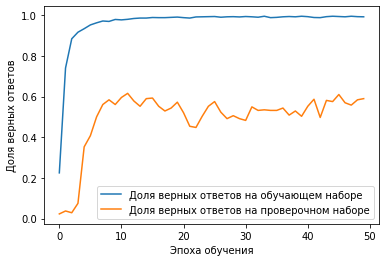

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

epochs = 50
name = "Embedding + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(Conv1D(16, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.3)) 
model.add(BatchNormalization())  

model.add(Flatten()) 
model.add(Dense(nClasses, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model1.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=16,
                    callbacks=[checkpoint_callback],
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [ ]:
# Загружаем лучшие найденные веса
model.load_weights('best_model1.h5')
score = model.evaluate(xTest, yTest)
score

11/11 [==============================] - 0s 3ms/step - loss: 1.4913 - accuracy: 0.6156


[1.49131178855896, 0.615606963634491]

In [ ]:
report(model, name)

0 Панкреатит Колит 0.7485286 1 НЕ ВЕРНО
1 Колит Колит 0.9062965 1 ВЕРНО
2 Гастрит Гастрит 0.6516728 40 ВЕРНО
3 Эзофагит Холицестит 0.437677 6 НЕ ВЕРНО
4 Гепатит Эзофагит 0.73037624 1 НЕ ВЕРНО
5 Панкреатит Эзофагит 0.24381226 16 НЕ ВЕРНО
6 Эзофагит Эзофагит 0.4396487 1 ВЕРНО
7 Холицестит Холицестит 0.45717254 1 ВЕРНО
8 Дуоденит Дуоденит 0.54356426 1 ВЕРНО
9 Колит Язва 0.68880004 1 НЕ ВЕРНО
10 Холицестит Колит 0.62018424 1 НЕ ВЕРНО
11 Дуоденит Гастрит 0.80088687 4 НЕ ВЕРНО
12 Дуоденит Эзофагит 0.26375306 1 НЕ ВЕРНО
13 Холицестит Панкреатит 0.48403654 6 НЕ ВЕРНО
14 Аппендицит Аппендицит 0.4408452 1 ВЕРНО
15 Энтерит Энтерит 0.44988447 1 ВЕРНО
16 Колит Панкреатит 0.8630173 1 НЕ ВЕРНО
17 Панкреатит Эзофагит 0.42356667 1 НЕ ВЕРНО
18 Холицестит Аппендицит 0.26627842 1 НЕ ВЕРНО
19 Эзофагит Колит 0.38204142 1 НЕ ВЕРНО
20 Панкреатит Колит 0.56928015 1 НЕ ВЕРНО
21 Гепатит Язва 0.5195679 1 НЕ ВЕРНО
22 Эзофагит Эзофагит 0.25302067 1 ВЕРНО
23 Дуоденит Колит 0.41170993 1 НЕ ВЕРНО
24 Язва Эзофагит 0.45

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 50, 16)            0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 16)            64        
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 50, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 32)            6272      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 50, 32)           

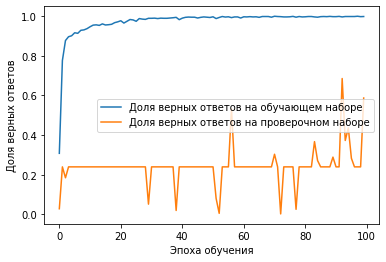

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

epochs = 100
name = "Embedding + Dense + LSTM + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(SpatialDropout1D(0.2)) 
model.add(LSTM(32, return_sequences=1)) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 
 
model.add(Conv1D(256, 5, activation="relu")) 
model.add(MaxPooling1D(2)) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.2)) 

model.add(Dense(nClasses, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model3.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[checkpoint_callback],
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Загружаем лучшие найденные веса
model.load_weights('best_model3.h5')
score = model.evaluate(xTest, yTest)
score

11/11 [==============================] - 0s 5ms/step - loss: 1.8099 - accuracy: 0.6850


[1.8098971843719482, 0.6849710941314697]

In [ ]:
report(model, name)

0 Панкреатит Панкреатит 0.61470586 1 ВЕРНО
1 Колит Гастрит 0.47497916 1 НЕ ВЕРНО
2 Гастрит Гастрит 0.53427815 40 ВЕРНО
3 Эзофагит Гастрит 0.4383287 6 НЕ ВЕРНО
4 Гепатит Гастрит 0.45933664 1 НЕ ВЕРНО
5 Панкреатит Гастрит 0.5011453 16 НЕ ВЕРНО
6 Эзофагит Гастрит 0.49626622 1 НЕ ВЕРНО
7 Холицестит Гастрит 0.40886962 1 НЕ ВЕРНО
8 Дуоденит Гастрит 0.5016572 1 НЕ ВЕРНО
9 Колит Панкреатит 0.374942 1 НЕ ВЕРНО
10 Холицестит Гастрит 0.65564734 1 НЕ ВЕРНО
11 Дуоденит Гастрит 0.6571908 4 НЕ ВЕРНО
12 Дуоденит Гастрит 0.4632535 1 НЕ ВЕРНО
13 Холицестит Панкреатит 0.51130444 6 НЕ ВЕРНО
14 Аппендицит Панкреатит 0.7087182 1 НЕ ВЕРНО
15 Энтерит Гастрит 0.39523253 1 НЕ ВЕРНО
16 Колит Гастрит 0.49260733 1 НЕ ВЕРНО
17 Панкреатит Гастрит 0.5266238 1 НЕ ВЕРНО
18 Холицестит Гастрит 0.7653797 1 НЕ ВЕРНО
19 Эзофагит Гастрит 0.5555054 1 НЕ ВЕРНО
20 Панкреатит Гастрит 0.43147662 1 НЕ ВЕРНО
21 Гепатит Панкреатит 0.41399562 1 НЕ ВЕРНО
22 Эзофагит Гастрит 0.39114887 1 НЕ ВЕРНО
23 Дуоденит Гастрит 0.4388672 1 НЕ ВЕРН

### Вариант 2

Сделайте оценку того, как блоки слов в словаре влияют на точность классификации (на любой базе, например, распознавание писателей). Для этого выполните следующее:
- Сформируйте словарь.
- Используйте первые 50000 слов.
- Разбейте все слова на блоки по 100 слов последовательно.
- Поочередно отключайте блоки по одному, то есть сделайте так, чтобы эти слова не использовались при обучении сети, например, их индексы всегда приравнивались к 0.
- Оцените, как меняется точность классификации на проверочной выборке.
- Сделайте выводы, какие блоки слов влияют в плюс, а какие в минус.
- Соберите итоговую подборку слов, в которую войдут только те блоки по 100 слов, которые улучшили точность (исключение которых давало падение точности).
- Обучите сеть только на этих блоках слов.
- Оцените изменение точности в сравнении с обучением на полном словаре (первые 50000 слов).



In [ ]:
# Загружаем базу писателей
!wget https://xland.ru/uai/hw04/writers.zip
!unzip -q 'writers.zip' -d /content/texts 

--2020-08-27 12:44:47--  https://xland.ru/uai/hw04/writers.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960427 (8.5M) [application/zip]
Saving to: ‘writers.zip’

writers.zip         100%[===================>]   8.54M  7.95MB/s    in 1.1s    

2020-08-27 12:44:49 (7.95 MB/s) - ‘writers.zip’ saved [8960427/8960427]



In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/texts/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/texts/(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/texts/(Рэй Брэдберри) Обучающая_22 вместе.txt')) 
# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/texts/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/texts/(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/texts/(Рэй Брэдберри) Тестовая_8 вместе.txt'))

In [ ]:
maxWordsCount = 50000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
tokenizer.fit_on_texts(trainText) 
items = list(tokenizer.word_index.items())

In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 16)          800000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 16)          64        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 20)           1620      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 20)           2020      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 247, 20)          

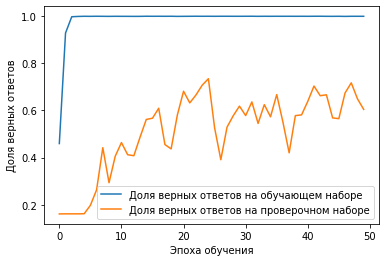

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

epochs = 50
name = "Embedding + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(Conv1D(20, 5, activation="relu")) 
model.add(MaxPooling1D(2)) 

model.add(Conv1D(20, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 

model.add(Flatten()) 
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[checkpoint_callback],
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [ ]:
# Загружаем лучшие найденные веса
model.load_weights('best_model.h5')

In [ ]:
# Тестируем модель на тестовой выборке
score = model.evaluate(xTest, yTest)

210/210 [==============================] - 1s 4ms/step - loss: 1.4737 - accuracy: 0.7348


In [ ]:
# Эта точность соответствует числу правильно распознаных блоков:
Ncor = len(xTest)*score[1]
Ncor 

4917.999917328358

In [ ]:
# Функция заменяет токены в тестовой выборке в указанном диапазоне на 1 
# Возвращает новую выборку, не меня исходной
def del100(xTest, i, bsize):
    low = i * bsize 
    high = low + bsize
    xTest_ = xTest.copy()
    for block in xTest_:
        for j, token in enumerate(block):
            if token > low and token <= high:
                block[j] = 1 # set out of vocabulary
    return xTest_


In [ ]:
# В цикле будем последовательно отключать по одному блоку из тестовой выборки. 
blockSize = 100
N = maxWordsCount // blockSize # N = 500
M = len(xTest)
data = np.zeros((N)) # list of accuracies.
for i in range(N): # в цикле по всем блокам словаря 
    xTest_ = del100(xTest, i, blockSize)
    score = model.evaluate(xTest_, yTest, verbose=0)
    data[i] = score[1]
    print(i, score[1], int(Ncor - score[1]*M) ) # Ncor = 4918 - число верно распознанных окон


0 0.3742716312408447 2412
1 0.6712983846664429 424
2 0.7035709023475647 208
3 0.708949625492096 173
4 0.7156730890274048 127
5 0.714328408241272 136
6 0.7203047871589661 96
7 0.7219483256340027 85
8 0.7226953506469727 80
9 0.7285223603248596 41
10 0.7243388891220093 69
11 0.7306140661239624 27
12 0.7292693853378296 36
13 0.732257604598999 16
14 0.7295681834220886 35
15 0.733004629611969 11
16 0.7295681834220886 35
17 0.7316599488258362 20
18 0.7286717295646667 41
19 0.7304646372795105 29
20 0.7304646372795105 29
21 0.7304646372795105 29
22 0.7315105199813843 22
23 0.7336022853851318 7
24 0.7259823679924011 58
25 0.7304646372795105 29
26 0.7319587469100952 19
27 0.733303427696228 10
28 0.7312117218971252 23
29 0.7352457642555237 -2
30 0.7336022853851318 7
31 0.7336022853851318 7
32 0.7340505123138428 4
33 0.7347975373268127 0
34 0.7303152680397034 29
35 0.7324069738388062 16
36 0.733303427696228 10
37 0.7349469661712646 -1
38 0.7359928488731384 -8
39 0.7339010834693909 5
40 0.7339010834

In [ ]:
# Составим список "плохих" блоков, чье отключение улучшило результат.
bad_blocks = []
for i in range(500):
    if data[i] > Ncor/len(xTest):
        bad_blocks.append(i)


In [ ]:
len(bad_blocks)

162

In [ ]:
# Посмотрим на слова, которые ухудшили распознавание больше всего:
items[7501:7600]

[('буривухов', 7502),
 ('расслабиться', 7503),
 ('бакки', 7504),
 ('всём', 7505),
 ('нумбане', 7506),
 ('игг', 7507),
 ('сфинкс', 7508),
 ('жохов', 7509),
 ('абилиу', 7510),
 ('нашсименту', 7511),
 ('маргарита', 7512),
 ('грэнджер', 7513),
 ('харт', 7514),
 ('красавица', 7515),
 ('гудвина', 7516),
 ('почве', 7517),
 ('получив', 7518),
 ('достиг', 7519),
 ('партия', 7520),
 ('гор', 7521),
 ('дорог', 7522),
 ('вздох', 7523),
 ('течет', 7524),
 ('пение', 7525),
 ('судно', 7526),
 ('мраке', 7527),
 ('тяжелую', 7528),
 ('превосходно', 7529),
 ('рай', 7530),
 ('послание', 7531),
 ('открытую', 7532),
 ('вкуса', 7533),
 ('офицера', 7534),
 ('беды', 7535),
 ('пробраться', 7536),
 ('сидите', 7537),
 ('видов', 7538),
 ('каменной', 7539),
 ('гостиницы', 7540),
 ('поесть', 7541),
 ('пульс', 7542),
 ('караван', 7543),
 ('стакана', 7544),
 ('родном', 7545),
 ('болотах', 7546),
 ('песке', 7547),
 ('соображений', 7548),
 ('кончик', 7549),
 ('убийц', 7550),
 ('суждено', 7551),
 ('государственного', 7552

In [ ]:
# Отключим все "плохие" блоки в тренировочной выборке:
xTrain_ = xTrain.copy()
for i in bad_blocks:
    xTrain_ = del100(xTrain_, i, blockSize)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 16)          800000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 16)          64        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 20)           1620      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 494, 20)           2020      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 247, 20)          

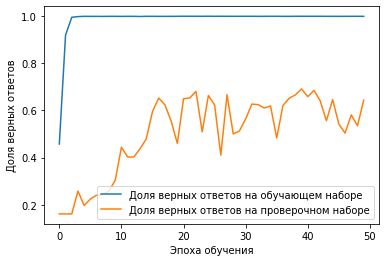

In [ ]:
# Повторим обучение модели на данных с выключенными "плохими" блоками слов
# Зафиксируем те же сиды для исключения случайного эффекта изменения точности.
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

epochs = 50
name = "Embedding + Conv1D"

model = Sequential() 
model.add(Embedding(maxWordsCount, 16, input_length=xLen))
model.add(SpatialDropout1D(0.2)) 
model.add(BatchNormalization())

model.add(Conv1D(20, 5, activation="relu")) 
model.add(MaxPooling1D(2)) 

model.add(Conv1D(20, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 

model.add(Flatten()) 
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model2.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history = model.fit(xTrain_, 
                    yTrain, 
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[checkpoint_callback],
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [ ]:
# Загружаем лучшие найденные веса
model.load_weights('best_model2.h5')

In [ ]:
# Повторно тестируем модель на тестовой выборке
score = model.evaluate(xTest, yTest)

210/210 [==============================] - 1s 4ms/step - loss: 1.9393 - accuracy: 0.6916


**ВЫВОД**

Выявлено 162 блоков (из 500) чье отключение из словаря привело к улучшению точности распознавания. Наибольший эффект дало отключение блока 75 (токены 7501-7600) - было распознано на 41 окно (по 1000 слов) больше.

Далее я последовательно добавлял отключение блоков (так что в конце были отключены все 75 блоков) Наибольший эффект дало совместое отключение блоков 75 и 95 (улучшение на 14 окон) дальнейшее отключение блоков стало ухудшать точность.
 Одновременное отключение всех "плохих" блоков ухудшило результат на 203 окна.

Сделал отключение "плохих" блоков тренировочной выборке и переобучение с теми же сидами (чтобы максимально уменьшить влияние случайного выбора начальных весов модели на результат) Проверка на тестовой выборке показала падение точности с 73% до 69%.

## Ultra PRO задание

Найдите любую базу с текстами разных классов и напишите их распознавание, используя рекуррентные или сверточные слои. Для этого выполните следующее:
- Спарсите тексты, превратите их в индексы.
- Разделите данные на обучающую и проверочную выборки.
- Напишите сеть для распознавания текстов.
- Сделайте визуализацию результата.
- Напишите ваши результаты и выводы.


Я взял одну из баз с сайта https://course.fast.ai/datasets#nlp

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
num_words = 10000
max_review_len = 100

In [ ]:
# загрузим файл архива БД
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2020-08-25 13:59:28--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2020-08-25 13:59:28--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ccb9d7ca1b40bcfb258a20009.dl.dropboxusercontent.com/cd/0/get/A-J-zYUZ8yJqq1OjNrOGUd2GfsRc1Bu_KLNx--RF9V8g_juca5fMMN_-vMw0eC-sLxOdFU55X7QGenoIVPdsfiYbzdAG3MZZka6hi9cN7o2J24t5WmCSAgQrOiGVokZi3QY/file?dl=1# [following]
--2020-08-25 13:59:29--  https://uc6ccb9d7ca1b40bcfb258a20009.dl.dropboxusercontent.com/cd/0/get/A-J-zYUZ8yJqq1OjNrOGUd2GfsRc1Bu_KLNx--RF9V8g_juca5fMMN_-vMw0e

In [ ]:
# Распакум в каталог
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [ ]:
# Выведем образец данных. 1-я колонка - тип отзыва 1 - отриц, 2- положительный
!head yelp_review_polarity_csv/test.csv

"2","Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
"1","Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the same issue. I called to complain, and the \""manager\"" didn't even apolog

In [ ]:
# Выведем число записей
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


In [ ]:
# читаем тренир. данные в dataframe pandas.
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [ ]:
# читаем тестовые данные в dataframe pandas.
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
# выделяем столбец с текстами
reviews = train['Review']

In [ ]:
# выделяем столбец с ответами
# приводим их к бинарному виду (0, 1)
y_train = train['Class'] - 1

In [ ]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

In [ ]:
# Создаем токенайзер и словарь 
#
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

In [ ]:
# Преобразуем слова в токены
sequences = tokenizer.texts_to_sequences(reviews)

In [ ]:
# Смотрим что получилось
index = 0
print(reviews[index])
print(sequences[index])

Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
[707, 1, 4339, 7, 173, 939, 1665, 11, 5, 2161, 7, 1, 137, 112, 24, 18, 27, 189, 80, 3128, 10, 2636, 34, 1416, 462, 129, 8, 519, 13, 177, 129, 803, 88, 3812, 1, 446, 8, 392, 841, 115, 360, 7, 4136, 1438, 4, 43, 59, 1266, 118, 95, 46, 9, 13, 49, 1687, 4, 418, 18, 8, 3, 23, 563, 178, 16, 460, 18, 189, 80, 3128, 2, 3, 40, 78, 43, 8, 20, 23, 644, 1343, 20, 23

In [ ]:
# Дополняем короткие отзывы до стандартной длины
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [ ]:
# Создаем модель
#
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
# Обучаем сеть
epochs = 15
history = model.fit(x_train, 
                    y_train, 
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/15
3499/3500 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9233
Epoch 00001: val_accuracy improved from -inf to 0.95329, saving model to best_model.h5
3500/3500 [==============================] - 172s 49ms/step - loss: 0.1925 - accuracy: 0.9233 - val_loss: 0.1223 - val_accuracy: 0.9533
Epoch 2/15
3500/3500 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9509
Epoch 00002: val_accuracy improved from 0.95329 to 0.95653, saving model to best_model.h5
3500/3500 [==============================] - 166s 47ms/step - loss: 0.1300 - accuracy: 0.9509 - val_loss: 0.1154 - val_accuracy: 0.9565
Epoch 3/15
3500/3500 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9617
Epoch 00003: val_accuracy improved from 0.95653 to 0.95715, saving model to best_model.h5
3500/3500 [==============================] - 161s 46ms/step - loss: 0.1031 - accuracy: 0.9617 - val_loss: 0.1153 - val_accuracy: 0.9572
Epoch 4/15
3499/3500 [=========

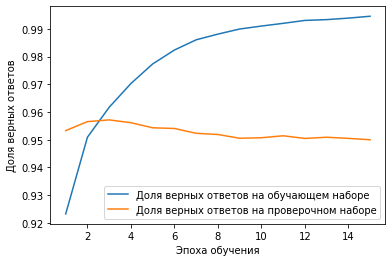

In [ ]:
# Выводим на график процесс обучения
e = [i + 1 for i in range(epochs)]
plt.plot(e, history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(e, history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Загружаем лучшие веса
model.load_weights(model_save_path)

In [ ]:
# Токенизируем тестовые отзывы
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
# Дополняем короткие отзывы до длины 100, приводим ответы к (0, 1)
x_test = pad_sequences(test_sequences, maxlen=max_review_len)
y_test = test['Class'] - 1

In [ ]:
# Запускаем модель на тестовых данных
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 13s 11ms/step - loss: 0.1343 - accuracy: 0.9491


[0.13431918621063232, 0.9491316080093384]

In [ ]:
# Сделаем свой тестовый негативный отзыв, попробуем его оценить.
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is disgusting and very expensive.  The host and waiters are rude. 
I will never visit the SmartBurger again!
'''

In [ ]:
# Преобразуем слова в токены
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
# Дополним до длины 100
data = pad_sequences(sequence, maxlen=max_review_len)

In [ ]:
# Получим вероятность что отзыв - положительный
result = model.predict(data)
result

array([[0.0001361]], dtype=float32)

In [ ]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')


Отзыв отрицательный


**ВЫВОД**

Для анализа тональности отзывов использована технология токенизации слов и преобразования токенов в вектора.

Была использована модель с Embedding-слоем и LSTM-слоем. Для регуляризации использовались слои BatchNormalization и Dropout.

Получена точность около 95% на тестовых данных.

### Бонус

Классика - набор отзывов IMDB из датасета keras

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
max_words=10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

In [ ]:
word_index = imdb.get_word_index()

In [ ]:
reverse_word_index = dict()
for key, value in word_index.items():
    reverse_word_index[value] = key

In [ ]:
for i in range(1, 21):
    print(i, '->', reverse_word_index[i])

1 -> the
2 -> and
3 -> a
4 -> of
5 -> to
6 -> is
7 -> br
8 -> in
9 -> it
10 -> i
11 -> this
12 -> that
13 -> was
14 -> as
15 -> for
16 -> with
17 -> movie
18 -> but
19 -> film
20 -> on


In [ ]:
index = 4
message = ''
for code in x_train[index]:
    word = reverse_word_index.get(code - 3, '?')
    message += word + ' '
message

"? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life "

In [ ]:
maxlen = 200

In [ ]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=maxlen))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 64)           256       
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 739,201
Trainable params: 739,073
Non-trainable params: 128
_________________________________________________________________


In [ ]:
# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_imdb_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=128,
                    callbacks=[checkpoint_callback],
                    validation_split=0.1)

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.6503
Epoch 00001: val_accuracy improved from -inf to 0.62920, saving model to best_imdb_model.h5
176/176 [==============================] - 12s 65ms/step - loss: 0.6001 - accuracy: 0.6503 - val_loss: 0.6670 - val_accuracy: 0.6292
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8190
Epoch 00002: val_accuracy did not improve from 0.62920
176/176 [==============================] - 11s 60ms/step - loss: 0.4497 - accuracy: 0.8190 - val_loss: 0.8251 - val_accuracy: 0.6152
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.7334
Epoch 00003: val_accuracy did not improve from 0.62920
176/176 [==============================] - 10s 59ms/step - loss: 0.5165 - accuracy: 0.7334 - val_loss: 0.7085 - val_accuracy: 0.5608
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8300
Epoch 00004: val_ac

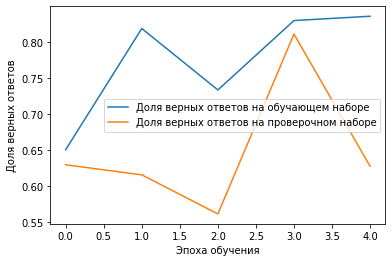

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.load_weights(model_save_path)

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 13s 17ms/step - loss: 0.5004 - accuracy: 0.7940
